# Overview: 

This notebook is created to do tasks given in issue no #5: [Calibration plot](https://github.com/mozilla/PRESC/issues/5)


## Task


- Write a function to create a **calibration plot** given one or more binary classifiers and a test set. 
- For each model it would compute **predicted probabilities** for each test datapoint. 
    - These probability values should then be **binned** according to a scheme (eg. intervals of 10%)
    - the observed occurrence rate can be computed as the **proportion of true positive class** samples out of all samples in each bin. 
- The plot then displays the observed **occurrence rates vs the bin midpoints** for each model.

--- 

Here I will avoide other cell discription except which are related to calibration plot and focus on it. I discribed those earlier. 


--- 

In [61]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#import matplotlib.pyplot as plt
#from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, roc_auc_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss

In [62]:
df = pd.read_csv("../../datasets/defaults.csv")

In [63]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})
# df.head()

In [64]:
# creating the target variable
y = df['def_pay'].copy()
# y.sample(5)

In [65]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = df[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

In [66]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [71]:
train = y_train
test = y_test

In [73]:
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [74]:
print(train.shape)
print(test.shape)

(24000, 25)
(6000, 25)


# Calibration plot



A calibration plot assesses how well the predicted class probabilities match the actual rate of occurrence in the dataset.


Calibration makes that the output of the models gives a true probability of a sample to belong to a particular class. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

For doing that, here I will use different models than before. 

In [75]:
def model_pred(clf, X_test):
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    return prob_pos

In [76]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = model_pred(clf, X_test) 
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
        if name == "Naive Bayes + Sigmoid":
            test_pred = model_pred(clf, test)
            submission["id"] = test_id
            submission["target"] = clf.predict_proba(test)[:, 1]
            submission.to_csv("submission.csv", index=False)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic:
	Brier: 0.167
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.404
	Precision: 0.246
	Recall: 0.883
	F1: 0.385

Naive Bayes + Isotonic:
	Brier: 0.157
	Precision: 0.558
	Recall: 0.180
	F1: 0.272

Naive Bayes + Sigmoid:
	Brier: 0.165
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



ValueError: operands could not be broadcast together with shapes (6000,25) (23,) 

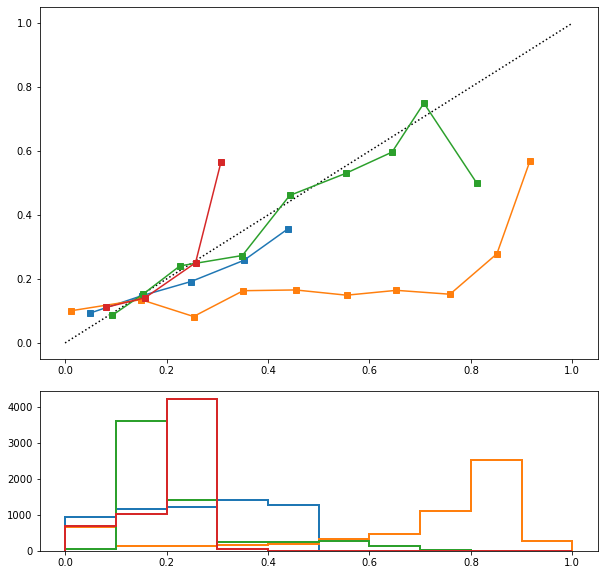

In [77]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

Logistic:
	Brier: 0.167
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

SVC:
	Brier: 0.675
	Precision: 0.600
	Recall: 0.016
	F1: 0.031

SVC + Isotonic:
	Brier: 0.164
	Precision: 1.000
	Recall: 0.001
	F1: 0.002

SVC + Sigmoid:
	Brier: 0.168
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



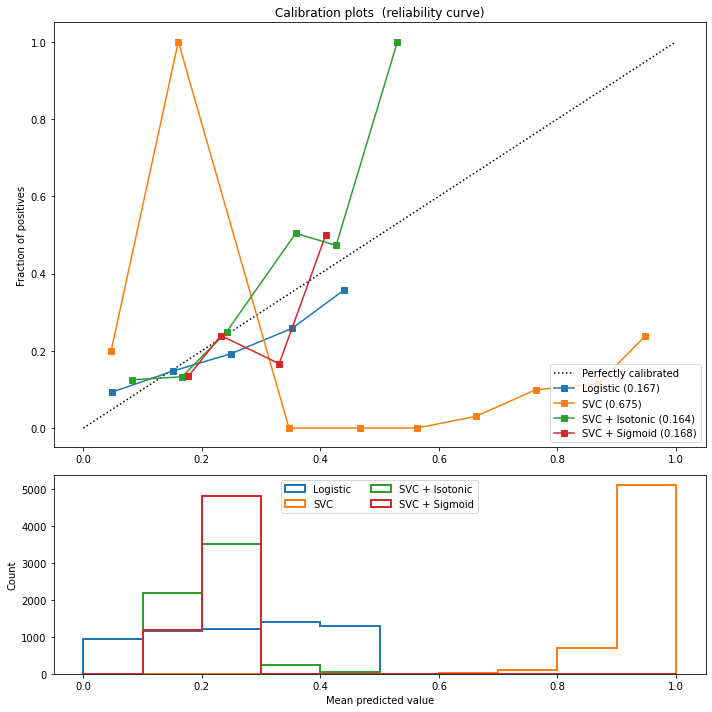

In [33]:
# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Brier scores: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


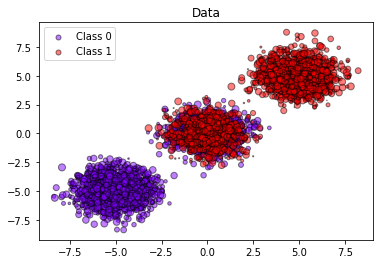

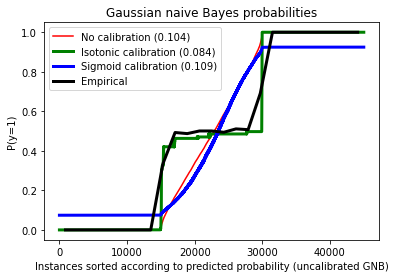

In [49]:
n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

# #############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)#returns [0,1]
#print(y_unique)
#print(y_unique.size)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
#print(colors.shape)
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color,
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()